# What happens if we modfiy the salary?

In [1]:
# To make relative imports work in notebooks
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# actual imports
from src.constants import YEARS, FIG_DIR, COURSES, SECTORS
from src.dataLoading import getTotalStudentsFor, getSalaries, getGraduatesInBwFor, getAllGraduatesYears, getInflationAdjustedGrossSalaries
from src.model import fitVarModel, predict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots import bundles

In [2]:
interestingYears = YEARS[3:-4]
totalStudents = getTotalStudentsFor(courses = COURSES, years = interestingYears)

inflationAdjustedGrossSalary = getInflationAdjustedGrossSalaries(SECTORS)
sallaries = getSalaries()

years = getAllGraduatesYears()
years = years[37:52]
graduatesInBW = getGraduatesInBwFor(years = years)
newVal = (graduatesInBW[4] + graduatesInBW[6])/2

/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4
/Users/paulkaifler/AnalysingStudentDevelopment/src/dataLoading.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '56919.375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  graduatesInBW.loc[2012, ('Abiturienten insg', 'Anzahl')] = newVal + diff / 4


### Build the model (once again)

In [3]:
LAGS = 5
PREDICTION_STPES = 2

In [4]:
dataset = np.column_stack((totalStudents, inflationAdjustedGrossSalary, graduatesInBW.repeat(2)))
results = fitVarModel(totalStudents, inflationAdjustedGrossSalary, graduatesInBW, lags=LAGS)
forecast = predict(results, 10)

/Users/paulkaifler/miniconda3/envs/data_literacy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/paulkaifler/miniconda3/envs/data_literacy/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


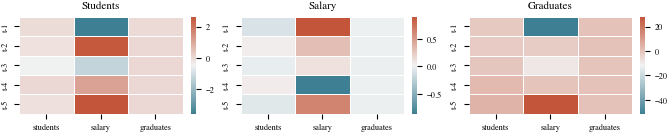

In [5]:
params = results.params.to_numpy()

paramsMatrices = []
titles = ['Students', 'Salary', 'Graduates']

for i in range(3):
    reshapedCoefficients = params[1:, i].reshape((LAGS, 3))
    df = pd.DataFrame(reshapedCoefficients)
    df.columns = ['students', 'salary', 'graduates']
    df.index = ['t-' + str(i) for i in range(1, LAGS + 1)]
    paramsMatrices.append(df)

plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=3, usetex=False))

fig, axs = plt.subplots(1, 3)

for i, df in enumerate(paramsMatrices):
    sns.heatmap(df, linewidths=0.5, ax=axs[i], cmap=sns.diverging_palette(220, 20, as_cmap=True))
    axs[i].set_title(titles[i])


plt.savefig(FIG_DIR + '/params.pdf')
plt.show()